# **Projet 5 :** Segmentez des clients d'un site e-commerce

## Notebook d'estimation de la periode d'update du modèle

### Import

In [1]:
%pylab inline
import pandas as pd
from jinja2 import Template
import seaborn as sns

from src.cluster import dataHelper, kmeanHelper

Populating the interactive namespace from numpy and matplotlib


### Configuration

In [2]:
%load_ext autoreload
%autoreload 2

# configurations pandas
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

### Chargement des données par SQL

In [3]:
DATABASE_URL = 'sqlite:///./db/olist.db'
with open('./db/template_script.sql', 'r') as file:
    template_query = Template(file.read())

In [4]:
PERIOD_1J = 60*60*24
PERIOD_1W = PERIOD_1J*7
PERIOD_1M = PERIOD_1J*30
PERIOD_2M = PERIOD_1J*30*2
PERIOD_3M = PERIOD_1J*30*3
PERIOD_6M = PERIOD_1J*30*6
PERIOD_1Y = PERIOD_1J*365

In [5]:
n_clusters = 5
columns = [
    'payment_value_sum',
    'order_id_count',
    'order_diff_now_purchase_date_min',
    'review_score_mean_mean'
]

In [25]:
query = template_query.render(period=PERIOD_1M)
df = pd.read_sql(sql=query, con=DATABASE_URL)
df.set_index('customer_unique_id', inplace=True)
df.shape

(58, 54)

In [26]:
df.head()

,order_id_count,order_status_delivered,order_status_invoiced,order_status_shipped,order_status_processing,order_status_unavailable,order_status_canceled,order_status_created,order_status_approved,order_diff_now_purchase_date_min,order_diff_now_purchase_date_max,order_diff_now_purchase_date_mean,order_diff_purchase_delivered_date_min,order_diff_purchase_delivered_date_max,order_diff_purchase_delivered_date_mean,order_diff_estimated_delivered_date_min,order_diff_estimated_delivered_date_max,order_diff_estimated_delivered_date_mean,order_items_count_sum,order_items_count_mean,product_category_name_distinct_count_mean,product_name_lenght_mean_mean,product_description_lenght_mean_mean,product_photos_qty_mean_mean,product_weight_g_mean_mean,product_volume_cm3_mean_mean,seller_zip_code_prefix_list,seller_zip_code_prefix_distinct_count_mean,shipping_limit_date_mean_mean,price_mean_mean,price_sum,freight_value_mean_mean,reviews_count_sum,reviews_count_mean,review_score_mean_mean,review_message_mean_mean,payments_count_sum,payments_count_mean,payment_credit_card_sum,payment_credit_card_mean,payment_debit_sum,payment_debit_mean,payment_boleto_sum,payment_boleto_mean,payment_voucher_sum,payment_voucher_mean,payment_not_defined_sum,payment_not_defined_mean,payment_installments_mean_mean,payment_value_mean_mean,payment_value_sum,customer_zip_code_prefix,geolocation_city,geolocation_state
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(0829f7df6577d5a4b65439bea701405f, 0829f7df6577d5a4b65439bea701405f)",1,1,0,0,0,0,0,0,0,175171454,175171454,175171454.0,531004,531004,531004.0,-4173250,-4173250,-4173250.0,1,1.0,1.0,43.0,259.0,1.0,610.0,4928.0,25645,1.0,1.476118e+09,249.90,249.90,17.59,1,1.0,3.0,0.0,1,1.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,10.0,267.49,267.49,31210,belo horizonte,mg
"(0acb54b64345b37d81205175f3f3e779, 0acb54b64345b37d81205175f3f3e779)",1,1,0,0,0,0,0,0,0,175154243,175154243,175154243.0,1463460,1463460,1463460.0,-3396383,-3396383,-3396383.0,1,1.0,1.0,27.0,293.0,4.0,3325.0,70574.0,82300,1.0,1.477068e+09,149.99,149.99,23.41,1,1.0,1.0,89.0,1,1.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,1.0,173.40,173.40,37701,pocos de caldas,mg
"(0b3dc7efaafb0cf78a4796d42fa8d74c, 0b3dc7efaafb0cf78a4796d42fa8d74c)",1,1,0,0,0,0,0,0,0,175165847,175165847,175165847.0,2229333,2229333,2229333.0,-2123714,-2123714,-2123714.0,1,1.0,1.0,43.0,259.0,1.0,610.0,4928.0,25645,1.0,1.477068e+09,249.90,249.90,14.03,1,1.0,5.0,31.0,1,1.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,2.0,263.93,263.93,22410,rio de janeiro,rj
"(0eb1ee9dba87f5b36b4613a65074337c, 0eb1ee9dba87f5b36b4613a65074337c)",1,0,0,0,0,0,1,0,0,175312328,175312328,175312328.0,31456328,31456328,31456328.0,29548800,29548800,29548800.0,1,1.0,1.0,32.0,561.0,1.0,500.0,5832.0,5503,1.0,1.477067e+09,100.00,100.00,9.34,1,1.0,1.0,0.0,1,1.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,1.0,109.34,109.34,2975,sao paulo,sp
"(10e89fd8e5c745f81bec101207ba4d7d, 10e89fd8e5c745f81bec101207ba4d7d)",1,1,0,0,0,0,0,0,0,175223310,175223310,175223310.0,1524726,1524726,1524726.0,-2972184,-2972184,-2972184.0,1,1.0,1.0,55.0,248.0,1.0,1800.0,9600.0,14940,1.0,1.477067e+09,74.90,74.90,17.37,1,1.0,1.0,119.0,1,1.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,3.0,92.27,92.27,35162,ipatinga,mg


In [8]:
from sklearn import cluster
from sklearn.metrics.cluster import adjusted_rand_score

n_weeks = [1, 2, 3, 4, 6, 8, 13, 17, 21, 26, 39, 52]
results = pd.DataFrame(columns=n_weeks)

reference_model = {}
reference_scaler = {}

for i in range(200):
    period = PERIOD_1W*i  # la periode est la semaine exprimé en secondes (60 * 60 * 24 * 7 * i)
    print("Period", i, ":", period)

    query = template_query.render(period=period)
    df = pd.read_sql(sql=query, con=DATABASE_URL)
    df.set_index('customer_unique_id', inplace=True)

    if df.shape[0] <= 0:
        print('End!')
        break
    else:
        print('df.shape:', df.shape)
    
    data_helper = dataHelper(df=df[columns])

    try:
        current_model = cluster.KMeans(n_clusters=n_clusters).fit(data_helper.get_data_scaled())
        current_label = current_model.labels_

        ari_score = {}
        for n in n_weeks:
            if i % n == 0 or n not in reference_model or n not in reference_scaler:
                print("Updated reference model %d weeks" % n)
                reference_model[n] = current_model
                reference_scaler[n] = data_helper.get_scaler()
            
            ari_score[n] = adjusted_rand_score(
                current_label,
                reference_model[n].predict(
                    reference_scaler[n].transform(data_helper.dataframe)
                )
            )

        results.loc[i, list(ari_score.keys())] = list(ari_score.values())
        print("ARI", i, ":", ari_score)
    except ValueError as error:
        print('ValueError:', error)
        # continue

Period 0 : 0
df.shape: (1, 54)
ValueError: n_samples=1 should be >= n_clusters=5.
Period 1 : 604800
df.shape: (2, 54)
ValueError: n_samples=2 should be >= n_clusters=5.
Period 2 : 1209600
df.shape: (2, 54)
ValueError: n_samples=2 should be >= n_clusters=5.
Period 3 : 1814400
df.shape: (2, 54)
ValueError: n_samples=2 should be >= n_clusters=5.
Period 4 : 2419200
df.shape: (2, 54)
ValueError: n_samples=2 should be >= n_clusters=5.
Period 5 : 3024000
df.shape: (254, 54)
Updated reference model 1 weeks
Updated reference model 2 weeks
Updated reference model 3 weeks
Updated reference model 4 weeks
Updated reference model 6 weeks
Updated reference model 8 weeks
Updated reference model 13 weeks
Updated reference model 17 weeks
Updated reference model 21 weeks
Updated reference model 26 weeks
Updated reference model 39 weeks
Updated reference model 52 weeks
ARI 5 : {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 6: 1.0, 8: 1.0, 13: 1.0, 17: 1.0, 21: 1.0, 26: 1.0, 39: 1.0, 52: 1.0}
Period 6 : 3628800
df.shape

(106, 12)


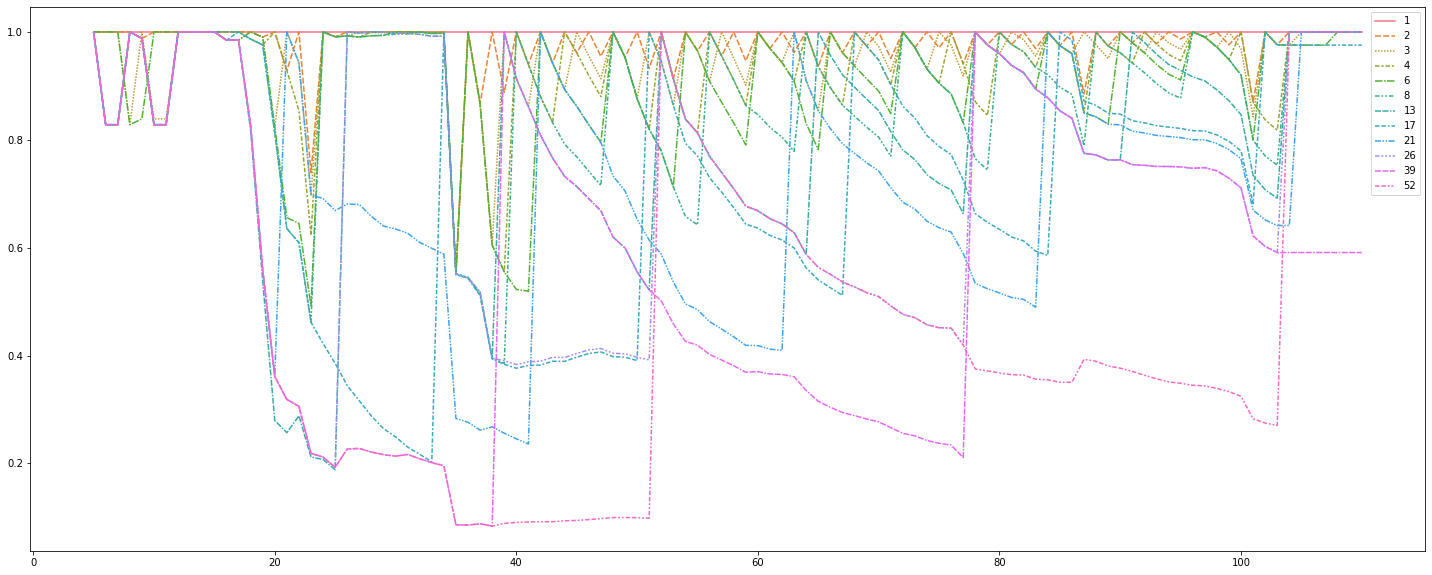

In [9]:
plt.figure(figsize=(25,10))
print(results.shape)
_ = sns.lineplot(data=results)

In [10]:
chart_data = [
    ['weeks', *results.index.to_list()],
    *[
        [str(c), *results[c].to_list()]
        for c in results.columns.to_list()
    ]
]
str(chart_data)

"[['weeks', 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110], ['1', 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ['2', 1.0, 1.0, 1.0,

### Export du notebook en HTML

In [11]:
!jupyter nbconvert --config nbconvert/config_html.py

[NbConvertApp] Converting notebook P5_01_notebooknettoyage.ipynb to html
[NbConvertApp] Writing 614907 bytes to P5_01_notebooknettoyage.html
[NbConvertApp] Converting notebook P5_02_notebookanalyse.ipynb to html
[NbConvertApp] Writing 26125257 bytes to P5_02_notebookanalyse.html
[NbConvertApp] Converting notebook P5_03_notebookproduction.ipynb to html
[NbConvertApp] Writing 997545 bytes to P5_03_notebookproduction.html
